# Problem statement

Based on various meteorological surveys and people's styles, the bike-sharing service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

__The company wants to know:__

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Reading and understand the Data

In [2]:
# Reading data
data = pd.read_csv('day.csv', index_col='instant')
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
data.shape

(730, 15)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


- There are no missing values in the data set

In [6]:
# Converting season, weathersit and weekday variable to categorical

In [7]:
# 1:spring, 2:summer, 3:fall, 4:winter
def season(x):
    return x.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'}) 

In [8]:
data[['season']] = data[['season']].apply(season)

In [9]:
data['season'].unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

In [10]:
# weathersit : 
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
def weather(x):
    return x.map({1:'Clear_FeworPartly_Clouds', 2:'MistorBroken_Clouds', 3:'Snow_Rain_ScatteredClouds', 4:'HeavyRain_Thunderstorm_IcePallets'}) 

In [11]:
data[['weathersit']] = data[['weathersit']].apply(weather)

In [12]:
data['weathersit'].unique()

array(['MistorBroken_Clouds', 'Clear_FeworPartly_Clouds',
       'Snow_Rain_ScatteredClouds'], dtype=object)

- There are no booking for bike if the weather is 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [14]:
# Weekday
# 0 : Sunday
# 1 : Monday
# 2 : Tuesady
# 3 : Wednesday
# 4 : Thursday
# 5 : Friday
# 6 : Saturday
def week(x):
    return x.map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}) 

In [15]:
data[['weekday']] = data[['weekday']].apply(week)

In [16]:
data['weekday'].unique()

array(['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'], dtype=object)

In [17]:
data.describe()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,6.526027,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,0.500343,3.450215,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,0.000000,1.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,0.000000,4.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,0.500000,7.000000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,1.000000,10.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,1.000000,12.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Visualising the data.

### Visualize the continous variables

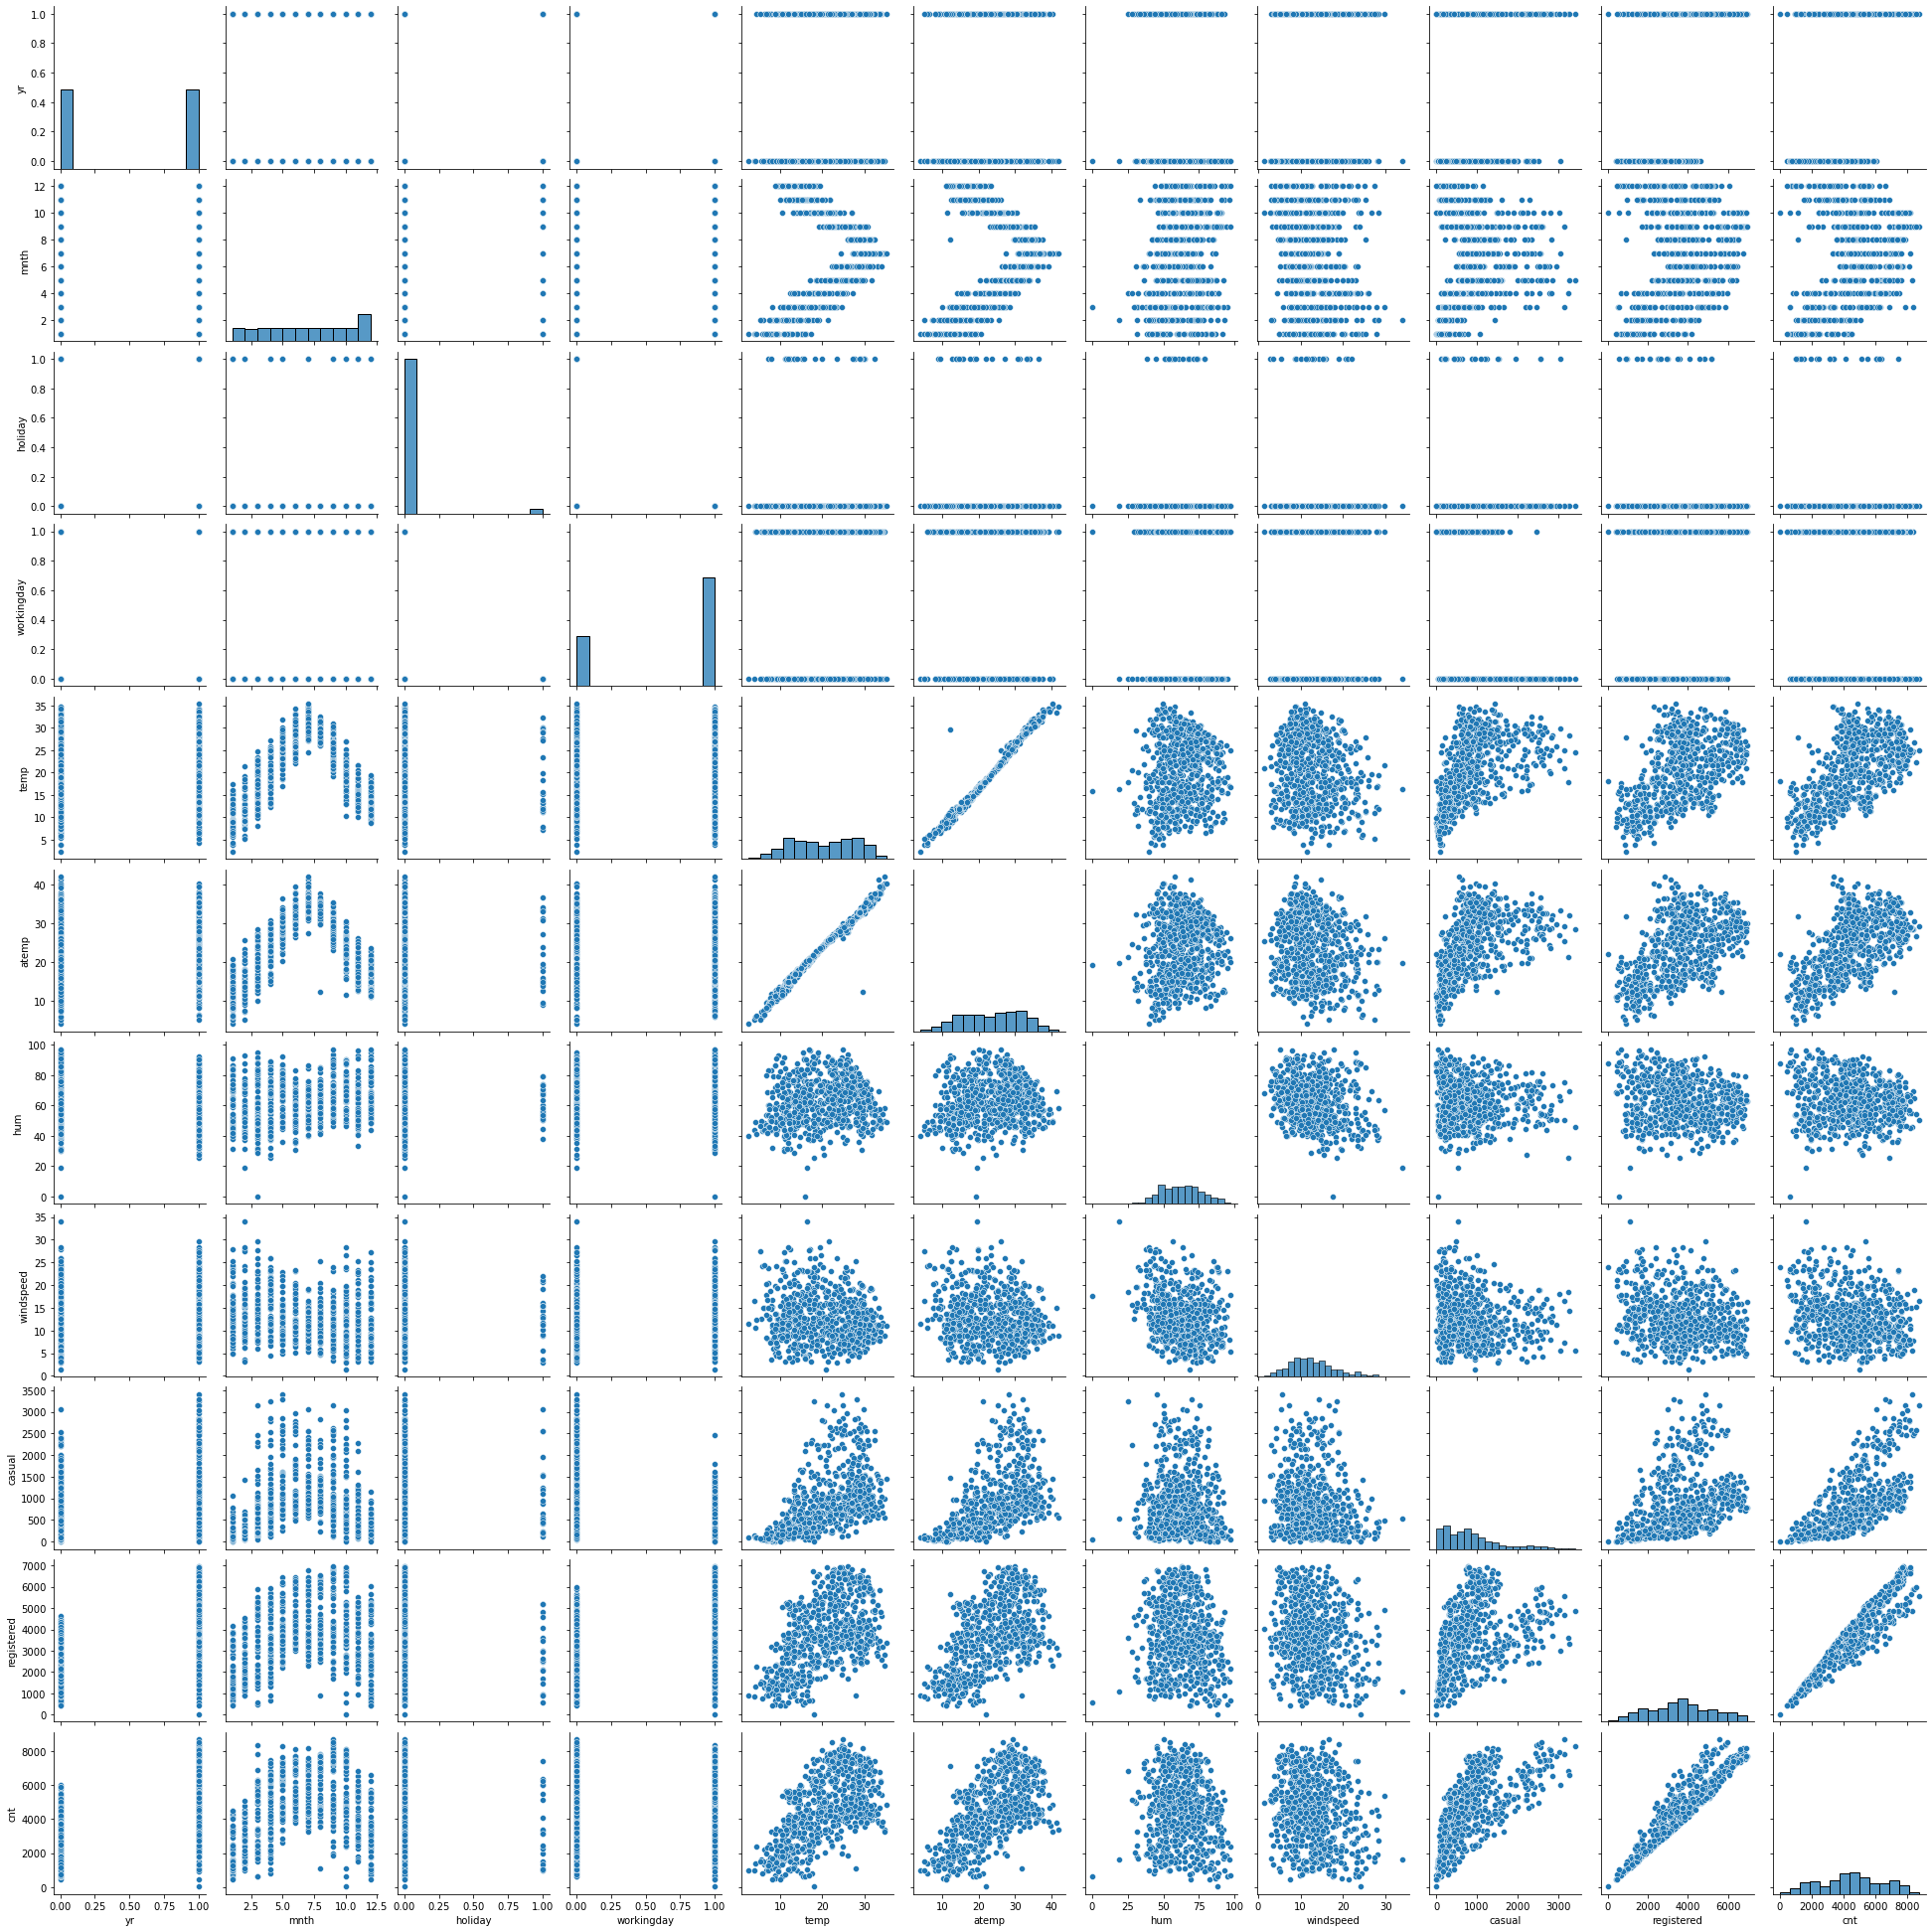

In [18]:
sns.pairplot(data)
plt.show()

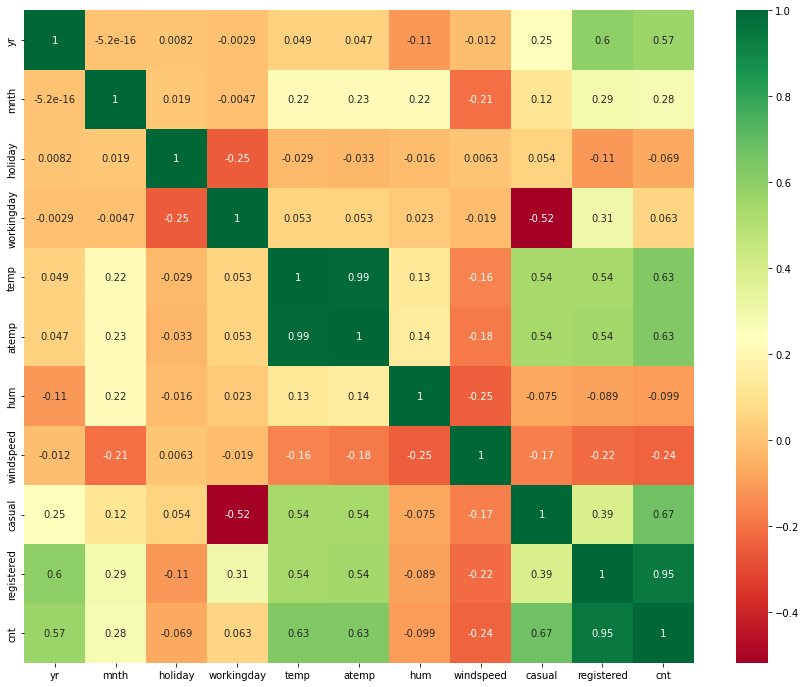

In [19]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")
plt.show()

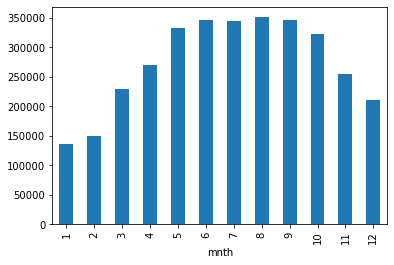

In [20]:
data.groupby(['mnth'])['cnt'].sum().plot.bar()
plt.show()

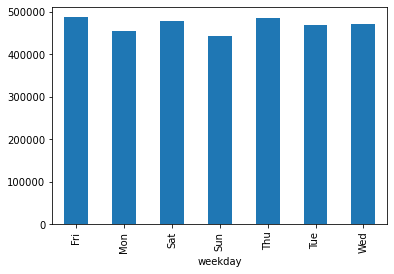

In [21]:
data.groupby(['weekday'])['cnt'].sum().plot.bar()
plt.show()

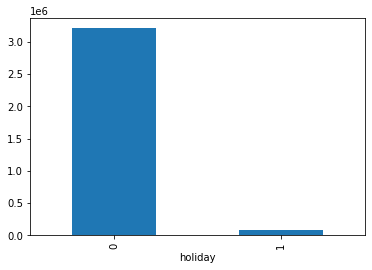

In [22]:
data.groupby(['holiday'])['cnt'].sum().plot.bar()
plt.show()

__Insights:-__
- atemp and temp has high correlation. we can drop one of these columns.
- Registered and casual has high correlation with count. And also have 0.39 correlation with each other. since registered and casual are also count of booking type we can delete them.
- temp and atemp also have good correlation with cnt target variable.
- May to October have highest number of bookings.
- Friday saturday and thursday has slightly more number of booking.
- Holiday 0(non holiday) have high number of bookings.

### Visualize the categorical variables

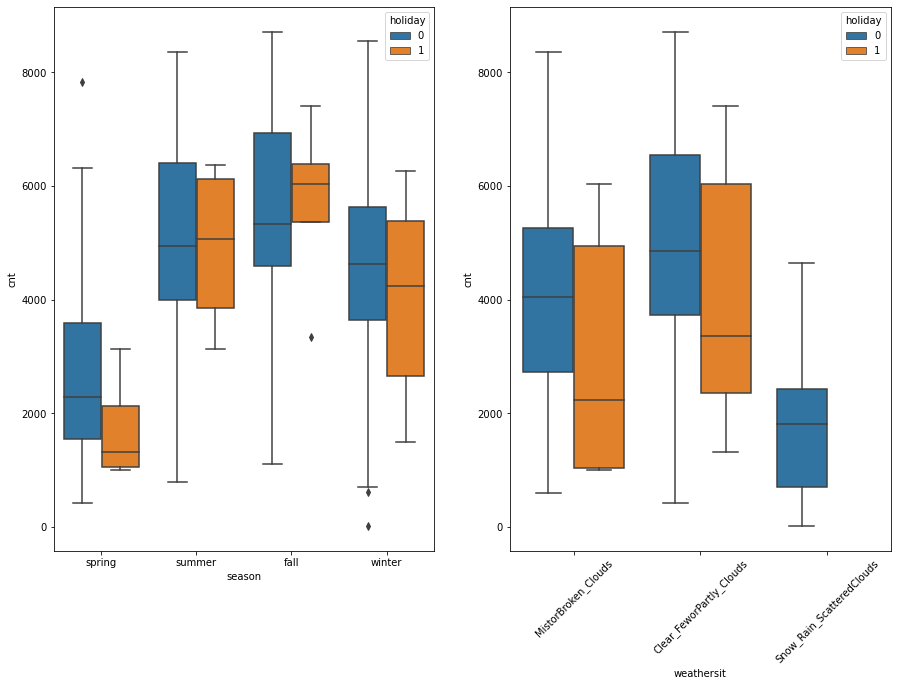

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(1,2, 1)
sns.boxplot(data = data, x = 'season', y = 'cnt', hue='holiday')
plt.subplot(1,2, 2)
sns.boxplot(data = data, x = 'weathersit', y = 'cnt', hue='holiday')
plt.xticks(rotation=45)
plt.show()

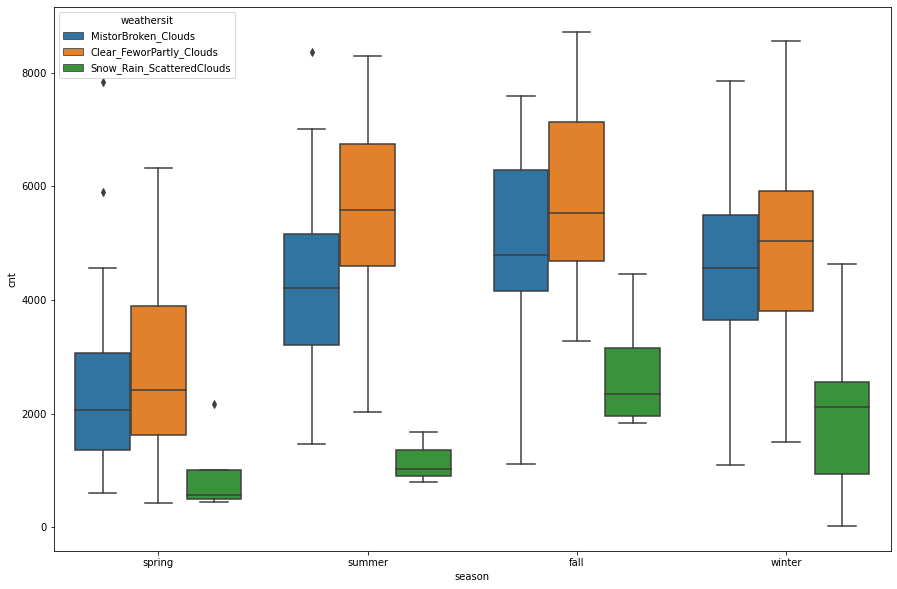

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(data = data, x = 'season', y = 'cnt', hue='weathersit')
plt.show()

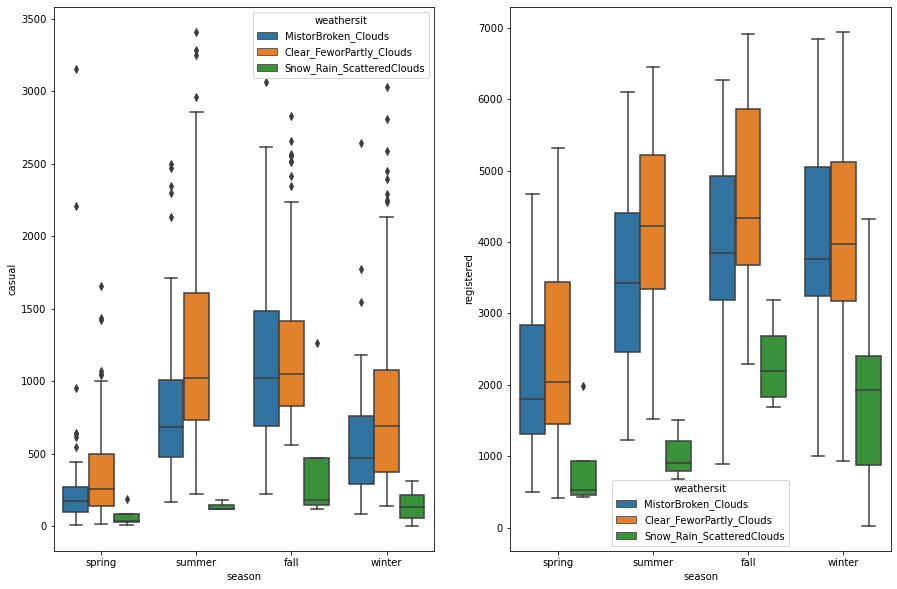

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(1,2, 1)
sns.boxplot(data = data, x = 'season', y = 'casual', hue='weathersit')
plt.subplot(1,2, 2)
sns.boxplot(data = data, x = 'season', y = 'registered', hue='weathersit')
plt.show()

<AxesSubplot:xlabel='yr', ylabel='cnt'>

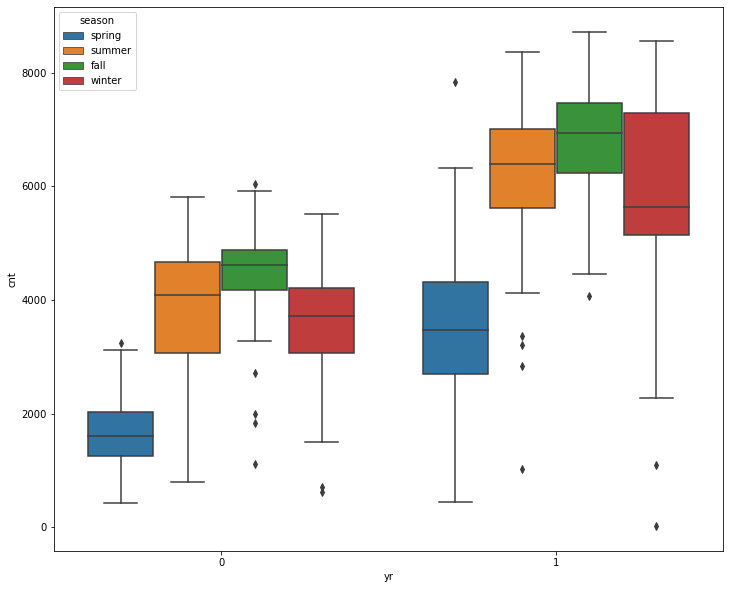

In [27]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data.yr, y=data.cnt, hue=data.season)

<AxesSubplot:xlabel='yr', ylabel='cnt'>

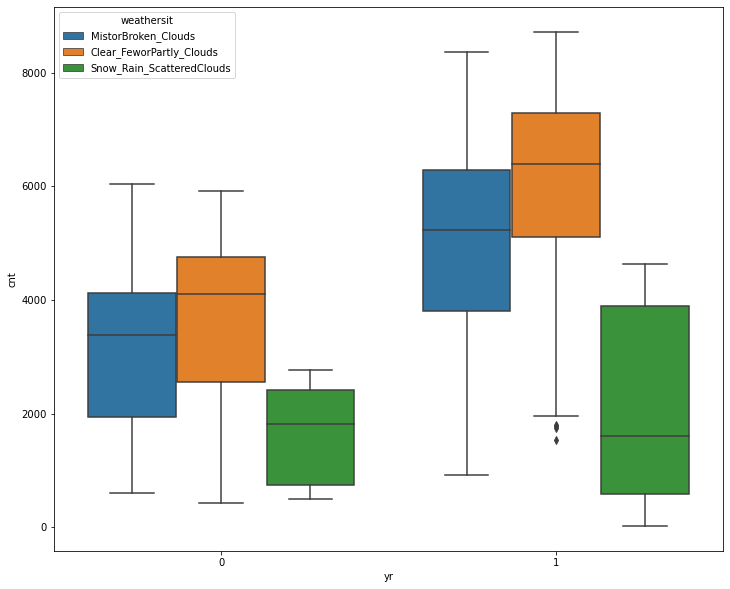

In [28]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data.yr, y=data.cnt, hue=data.weathersit)

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

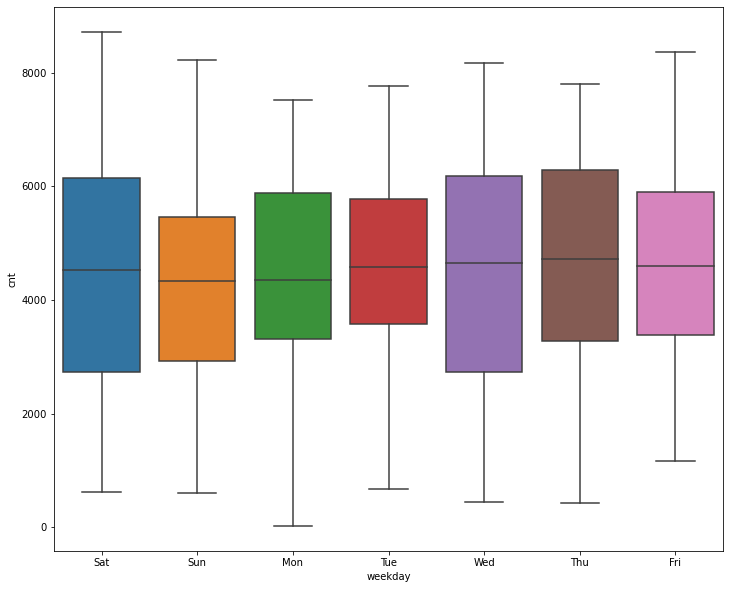

In [29]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data.weekday, y=data.cnt)

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

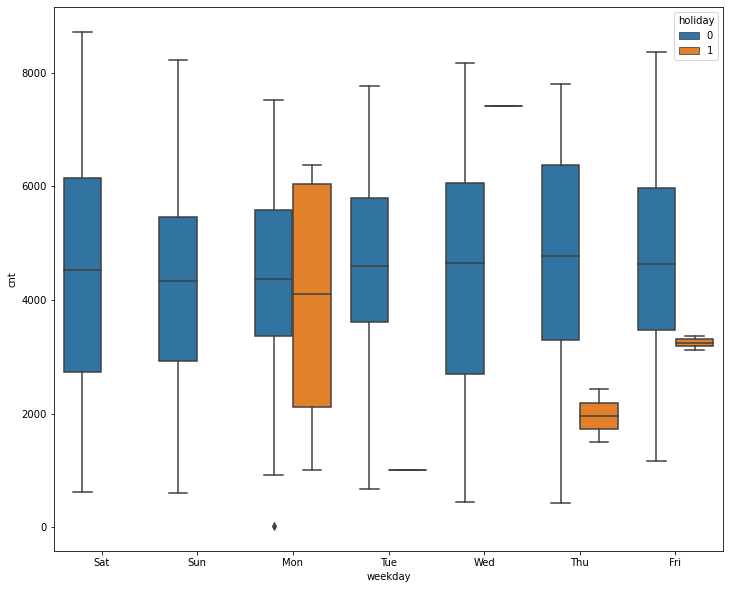

In [30]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data.weekday, y=data.cnt, hue=data.holiday)

__Insights:-__
- MistOrBroken_clouds and Clear_few/partly_Clouds weather have high bookings.
- Clearly number of bookings are increased in 2019
- And mistBroken_clouds and Clear_Few/Partly_Clouds weathers have seen more bookings in 2018 and 2019.
- Summer, fall and winter have large number of booking compared to spring season.
- Mondays have more booking on holidays.

In [32]:
# Deriving weeknumber(week of the month) variable from dteday variable.

In [33]:
data['dteday'] = data.dteday.apply(pd.to_datetime, infer_datetime_format=True)

In [34]:
# Extracting week number of the month from dteday variable.
def weeknumber(x):
    day_of_month = x.day
    return (day_of_month - 1) // 7 + 1

In [35]:
data['weeknumber'] = data['dteday'].apply(weeknumber)

<AxesSubplot:xlabel='weeknumber', ylabel='cnt'>

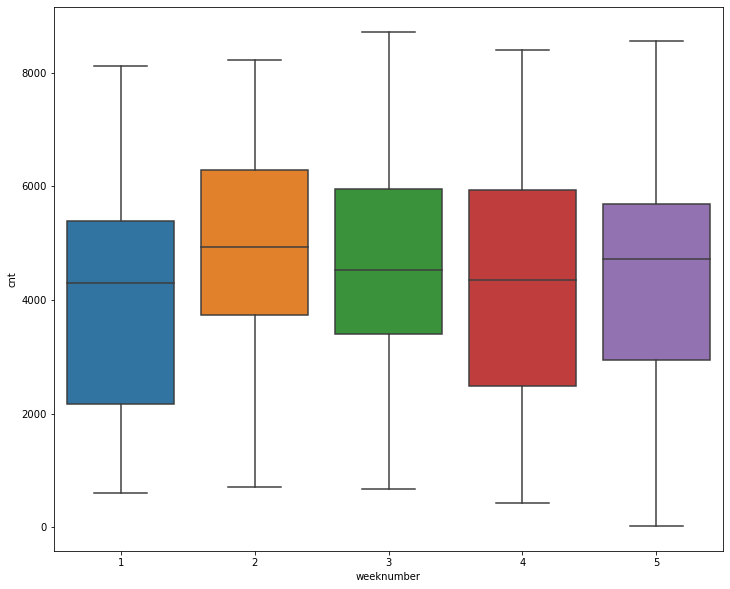

In [36]:
plt.figure(figsize=(12,10))
sns.boxplot(x=data.weeknumber, y=data.cnt)

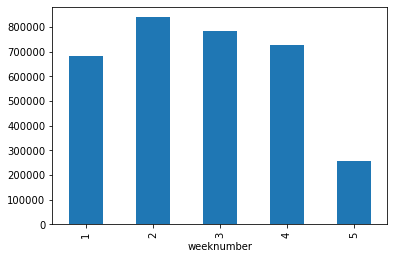

In [37]:
data.groupby(['weeknumber'])['cnt'].sum().plot.bar()
plt.show()

__Insights:-__
- second and third weeks of the months seem to have slightly more booking.

In [39]:
# we don't need dteday, casual, registered and atemp variables.
# 1. we already have month, year and weekday vaiables, so dteday is not required.
# 2. casual and registered are sub-category of cnt(target) variable, hence they are also not required.
# 3. atemp variable has highly correlated with temp variable. atemp is dependent on hum and windspeed. 
# As we already have humidity and windspeed variables we can drop atemp variable
# Droping the columns.
data.drop(['dteday','casual','registered','atemp'], axis = 1, inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,weeknumber
instant,,,,,,,,,,,,
1,spring,0,1,0,Sat,0,MistorBroken_Clouds,14.110847,80.5833,10.749882,985,1
2,spring,0,1,0,Sun,0,MistorBroken_Clouds,14.902598,69.6087,16.652113,801,1
3,spring,0,1,0,Mon,1,Clear_FeworPartly_Clouds,8.050924,43.7273,16.636703,1349,1
4,spring,0,1,0,Tue,1,Clear_FeworPartly_Clouds,8.200000,59.0435,10.739832,1562,1
5,spring,0,1,0,Wed,1,Clear_FeworPartly_Clouds,9.305237,43.6957,12.522300,1600,1


In [40]:
data.weeknumber.unique()

array([1, 2, 3, 4, 5])

### Preparing the Data for Modeling
- Encoding:
    1. Convering binary variables to 1/0.
    2. Other categorical variables to dummy variables.
- Spliting into train and test
- Rescaling of variables

In [41]:
varlist = [x for x in data.columns if data[x].dtype=='O']
varlist

['season', 'weekday', 'weathersit']

In [42]:
data.season.unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

In [43]:
data.weathersit.unique()

array(['MistorBroken_Clouds', 'Clear_FeworPartly_Clouds',
       'Snow_Rain_ScatteredClouds'], dtype=object)

In [44]:
data.weekday.unique()

array(['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'], dtype=object)

In [45]:
# Creating dummy variables for season
season_dummy = pd.get_dummies(data.season, drop_first=True)
season_dummy.head()

,spring,summer,winter
instant,,,
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [46]:
# 1 0 0 means Spring season
# 0 1 0 means Summer season
# 0 0 1 means Winter season
# 0 0 0 means Fall season

In [47]:
# Creating dummy variables for weathersit
weather_dummy = pd.get_dummies(data.weathersit, drop_first=True)
weather_dummy.head()

,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,
1,1,0
2,1,0
3,0,0
4,0,0
5,0,0


In [48]:
# HeavyRain_IcePallets weather have not bikes cnt. so its ignored.
# 1 0 means Mist_Clouds
# 0 1 means Snow_Rain
# 0 0 means Clear_Clouds

In [49]:
# Creating dummy variable for weekday
weekday_dummy = pd.get_dummies(data.weekday, drop_first=True)
weekday_dummy.head()

,Mon,Sat,Sun,Thu,Tue,Wed
instant,,,,,,
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0
5,0,0,0,0,0,1


In [50]:
# 0 0 0 0 0 0 means Friday
# 1 0 0 0 0 0 means Monday
# 0 1 0 0 0 0 means Saturday
# 0 0 1 0 0 0 means Sunday
# 0 0 0 1 0 0 means Thuday
# 0 0 0 0 1 0 means Tueday
# 0 0 0 0 0 1 means Wednesday

In [51]:
# Concat the dummy season and weather variable with the original one.
data = pd.concat([data, season_dummy], axis=1)
data.drop('season', inplace=True, axis=1)

In [52]:
data = pd.concat([data, weekday_dummy], axis=1)
data.drop('weekday', inplace=True, axis=1)

In [53]:
data = pd.concat([data, weather_dummy], axis=1)
data.drop('weathersit', inplace=True, axis=1)
data.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt,weeknumber,spring,summer,winter,Mon,Sat,Sun,Thu,Tue,Wed,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,14.110847,80.5833,10.749882,985,1,1,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,14.902598,69.6087,16.652113,801,1,1,0,0,0,0,1,0,0,0,1,0
3,0,1,0,1,8.050924,43.7273,16.636703,1349,1,1,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,8.200000,59.0435,10.739832,1562,1,1,0,0,0,0,0,0,1,0,0,0
5,0,1,0,1,9.305237,43.6957,12.522300,1600,1,1,0,0,0,0,0,0,0,1,0,0


In [54]:
# Train-Test split
train, test = train_test_split(data, test_size= .3,random_state=50)

In [55]:
train.shape, test.shape

((511, 20), (219, 20))

In [56]:
# Rescaling the Features
# Using Min-Max scaling (Normalization): Between 0 and 1

In [57]:
sc = MinMaxScaler()
train[train.columns] = sc.fit_transform(train[train.columns])
test[test.columns] = sc.transform(test[test.columns])

In [58]:
train.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt,weeknumber,spring,summer,winter,Mon,Sat,Sun,Thu,Tue,Wed,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,,,,,,,,,,,,,,,,,,,
708,1.0,1.000000,0.0,0.0,0.417140,0.933018,0.243629,0.368845,0.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
173,0.0,0.454545,0.0,1.0,0.865247,0.729068,0.274549,0.515992,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0.0,0.000000,0.0,0.0,0.223565,0.513954,0.243603,0.141049,0.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
205,0.0,0.545455,0.0,0.0,0.989306,0.567625,0.267859,0.412333,0.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.545455,0.0,0.0,0.871664,0.458136,0.150755,0.586401,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
test.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,cnt,weeknumber,spring,summer,winter,Mon,Sat,Sun,Thu,Tue,Wed,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,,,,,,,,,,,,,,,,,,,
334,0.0,0.909091,0.0,1.0,0.341207,0.632030,0.488582,0.413139,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
204,0.0,0.545455,0.0,0.0,1.013904,0.515242,0.185727,0.375403,0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
280,0.0,0.818182,0.0,1.0,0.579699,0.705024,-0.049804,0.570985,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,1.0,0.272727,0.0,0.0,0.512322,0.604980,0.154750,0.722734,1.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
268,0.0,0.727273,0.0,0.0,0.737981,0.870760,0.010767,0.573861,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Training the model
- Statistical significance of the variables
- VIF

In [60]:
# Create X_train and y_train
y_train = train.pop('cnt')
X_train = train

In [61]:
# Create X_test and y_test
y_test = test.pop('cnt')
X_test = test

In [62]:
X_test.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,weeknumber,spring,summer,winter,Mon,Sat,Sun,Thu,Tue,Wed,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,,,,,,,,,,,,,,,,,,
334,0.0,0.909091,0.0,1.0,0.341207,0.632030,0.488582,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
204,0.0,0.545455,0.0,0.0,1.013904,0.515242,0.185727,0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
280,0.0,0.818182,0.0,1.0,0.579699,0.705024,-0.049804,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,1.0,0.272727,0.0,0.0,0.512322,0.604980,0.154750,1.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
268,0.0,0.727273,0.0,0.0,0.737981,0.870760,0.010767,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [63]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [64]:
# Create first model
lr = sm.OLS(y_train, X_train_sm)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     149.2
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          5.21e-186
Time:                        20:54:38   Log-Likelihood:                 518.20
No. Observations:                 511   AIC:                            -998.4
Df Residuals:                     492   BIC:                            -917.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2405      0.030      8.022      0.000       0.182       0.299
yr                            0.2307      0.008     28.699      0.000       0.215       0.247
mnth                         -0.0202      0.024     -0.844      0.399      -0.067       0.027
holiday                       0.0286      0.024      1.196      0.232      -0.018       0.075
workingday                    0.0860      0.011      7.524      0.000       0.064       0.108
temp                          0.5248      0.033     15.922      0.000       0.460       0.590
hum                          -0.1783      0.037     -4.757      0.000      -0.252      -0.105
windspeed                    -0.1798      0.026     -6.959      0.000      -0.231      -0.129
weeknumber                   -0.0305      0.013     -2.357      0.019      -0.056      -0.005
spring                       -0.0799      0.022     -3.556      0.000      -0.124      -0.036
summer                        0.0391      0.015      2.671      0.008       0.010       0.068
winter                        0.1038      0.018      5.730      0.000       0.068       0.139
Mon                          -0.0272      0.015     -1.822      0.069      -0.057       0.002
Sat                           0.0900      0.013      6.743      0.000       0.064       0.116
Sun                           0.0359      0.013      2.675      0.008       0.010       0.062
Thu                          -0.0014      0.015     -0.092      0.927      -0.031       0.028
Tue                          -0.0254      0.015     -1.724      0.085      -0.054       0.004
Wed                          -0.0152      0.015     -1.009      0.314      -0.045       0.014
MistorBroken_Clouds          -0.0430      0.011     -4.009      0.000      -0.064      -0.022
Snow_Rain_ScatteredClouds    -0.2109      0.026     -8.098      0.000      -0.262      -0.160
==============================================================================
Omnibus:                       57.873   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.756
Skew:                          -0.594   Prob(JB):                     4.49e-31
Kurtosis:                       5.270   Cond. No.                     2.04e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.29e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [65]:
vif = pd.DataFrame()
X = X_train
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,workingday,63.55
13,Sun,12.46
12,Sat,12.33
8,spring,5.96
10,winter,3.96
4,temp,3.68
1,mnth,3.62
2,holiday,3.25
9,summer,2.59
5,hum,2.00


In [66]:
# Removing vaiables based on p-value and VIF
# High p-value, high VIF: no brainer remove
# High-low
# High p-value, low VIF: remove these first(high p-value)
# Low p-value, high VIF: remove after first(high VIF) 

In [67]:
# removing 'Thu' as it has 0.92 p-value
var_remove = ['Thu']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     158.3
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          4.10e-187
Time:                        20:54:38   Log-Likelihood:                 518.19
No. Observations:                 511   AIC:                            -1000.
Df Residuals:                     493   BIC:                            -924.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2403      0.030      8.042      0.000       0.182       0.299
yr                            0.2307      0.008     28.733      0.000       0.215       0.247
mnth                         -0.0202      0.024     -0.847      0.398      -0.067       0.027
holiday                       0.0282      0.023      1.200      0.231      -0.018       0.074
workingday                    0.0856      0.011      8.100      0.000       0.065       0.106
temp                          0.5248      0.033     15.938      0.000       0.460       0.589
hum                          -0.1783      0.037     -4.764      0.000      -0.252      -0.105
windspeed                    -0.1800      0.026     -6.987      0.000      -0.231      -0.129
weeknumber                   -0.0305      0.013     -2.359      0.019      -0.056      -0.005
spring                       -0.0799      0.022     -3.562      0.000      -0.124      -0.036
summer                        0.0391      0.015      2.674      0.008       0.010       0.068
winter                        0.1038      0.018      5.736      0.000       0.068       0.139
Mon                          -0.0265      0.013     -2.055      0.040      -0.052      -0.001
Sat                           0.0903      0.013      6.984      0.000       0.065       0.116
Sun                           0.0362      0.013      2.778      0.006       0.011       0.062
Tue                          -0.0247      0.013     -1.947      0.052      -0.050       0.000
Wed                          -0.0145      0.013     -1.114      0.266      -0.040       0.011
MistorBroken_Clouds          -0.0429      0.011     -4.014      0.000      -0.064      -0.022
Snow_Rain_ScatteredClouds    -0.2110      0.026     -8.114      0.000      -0.262      -0.160
==============================================================================
Omnibus:                       57.757   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.268
Skew:                          -0.594   Prob(JB):                     5.73e-31
Kurtosis:                       5.265   Cond. No.                     2.04e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.29e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [68]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,workingday,61.72
13,Sun,12.45
12,Sat,12.32
8,spring,5.95
10,winter,3.96
4,temp,3.68
1,mnth,3.61
2,holiday,3.20
9,summer,2.59
5,hum,2.00


In [69]:
# removing 'mnth' as it has 0.398 p-value
var_remove = ['Thu', 'mnth']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.2
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          4.44e-188
Time:                        20:54:39   Log-Likelihood:                 517.82
No. Observations:                 511   AIC:                            -1002.
Df Residuals:                     494   BIC:                            -929.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2316      0.028      8.261      0.000       0.176       0.287
yr                            0.2305      0.008     28.730      0.000       0.215       0.246
holiday                       0.0252      0.023      1.085      0.279      -0.020       0.071
workingday                    0.0836      0.010      8.117      0.000       0.063       0.104
temp                          0.5251      0.033     15.956      0.000       0.460       0.590
hum                          -0.1806      0.037     -4.837      0.000      -0.254      -0.107
windspeed                    -0.1799      0.026     -6.986      0.000      -0.231      -0.129
weeknumber                   -0.0311      0.013     -2.408      0.016      -0.056      -0.006
spring                       -0.0717      0.020     -3.546      0.000      -0.111      -0.032
summer                        0.0444      0.013      3.375      0.001       0.019       0.070
winter                        0.0981      0.017      5.842      0.000       0.065       0.131
Mon                          -0.0266      0.013     -2.061      0.040      -0.052      -0.001
Sat                           0.0881      0.013      6.959      0.000       0.063       0.113
Sun                           0.0347      0.013      2.687      0.007       0.009       0.060
Tue                          -0.0241      0.013     -1.905      0.057      -0.049       0.001
Wed                          -0.0145      0.013     -1.114      0.266      -0.040       0.011
MistorBroken_Clouds          -0.0429      0.011     -4.019      0.000      -0.064      -0.022
Snow_Rain_ScatteredClouds    -0.2107      0.026     -8.106      0.000      -0.262      -0.160
==============================================================================
Omnibus:                       57.648   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.889
Skew:                          -0.593   Prob(JB):                     6.93e-31
Kurtosis:                       5.262   Cond. No.                     1.34e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.14e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
2,workingday,54.45
12,Sun,11.17
11,Sat,10.87
7,spring,4.83
3,temp,3.68
9,winter,3.41
1,holiday,2.91
8,summer,2.10
4,hum,1.99
15,MistorBroken_Clouds,1.65


In [71]:
# removing 'holiday' as it has 0.279 p-value
var_remove = ['Thu', 'mnth', 'holiday']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.2
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          4.44e-188
Time:                        20:54:39   Log-Likelihood:                 517.82
No. Observations:                 511   AIC:                            -1002.
Df Residuals:                     494   BIC:                            -929.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2567      0.044      5.839      0.000       0.170       0.343
yr                            0.2305      0.008     28.730      0.000       0.215       0.246
workingday                    0.0584      0.027      2.149      0.032       0.005       0.112
temp                          0.5251      0.033     15.956      0.000       0.460       0.590
hum                          -0.1806      0.037     -4.837      0.000      -0.254      -0.107
windspeed                    -0.1799      0.026     -6.986      0.000      -0.231      -0.129
weeknumber                   -0.0311      0.013     -2.408      0.016      -0.056      -0.006
spring                       -0.0717      0.020     -3.546      0.000      -0.111      -0.032
summer                        0.0444      0.013      3.375      0.001       0.019       0.070
winter                        0.0981      0.017      5.842      0.000       0.065       0.131
Mon                          -0.0266      0.013     -2.061      0.040      -0.052      -0.001
Sat                           0.0629      0.030      2.105      0.036       0.004       0.122
Sun                           0.0095      0.030      0.318      0.751      -0.049       0.068
Tue                          -0.0241      0.013     -1.905      0.057      -0.049       0.001
Wed                          -0.0145      0.013     -1.114      0.266      -0.040       0.011
MistorBroken_Clouds          -0.0429      0.011     -4.019      0.000      -0.064      -0.022
Snow_Rain_ScatteredClouds    -0.2107      0.026     -8.106      0.000      -0.262      -0.160
==============================================================================
Omnibus:                       57.648   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.889
Skew:                          -0.593   Prob(JB):                     6.93e-31
Kurtosis:                       5.262   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,hum,33.01
1,workingday,20.82
2,temp,18.72
11,Sun,5.07
10,Sat,4.96
4,windspeed,4.95
6,spring,4.68
8,winter,3.67
5,weeknumber,2.88
7,summer,2.51


In [73]:
# removing 'sunday' as it has 0.751 p-value
var_remove = ['Thu', 'mnth', 'holiday', 'Sun']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.8
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          3.42e-189
Time:                        20:54:39   Log-Likelihood:                 517.77
No. Observations:                 511   AIC:                            -1004.
Df Residuals:                     495   BIC:                            -935.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2649      0.036      7.426      0.000       0.195       0.335
yr                            0.2305      0.008     28.759      0.000       0.215       0.246
workingday                    0.0507      0.012      4.245      0.000       0.027       0.074
temp                          0.5249      0.033     15.967      0.000       0.460       0.589
hum                          -0.1802      0.037     -4.835      0.000      -0.253      -0.107
windspeed                    -0.1802      0.026     -7.008      0.000      -0.231      -0.130
weeknumber                   -0.0309      0.013     -2.399      0.017      -0.056      -0.006
spring                       -0.0718      0.020     -3.554      0.000      -0.111      -0.032
summer                        0.0446      0.013      3.398      0.001       0.019       0.070
winter                        0.0981      0.017      5.847      0.000       0.065       0.131
Mon                          -0.0280      0.012     -2.306      0.022      -0.052      -0.004
Sat                           0.0546      0.015      3.682      0.000       0.025       0.084
Tue                          -0.0246      0.013     -1.959      0.051      -0.049    6.63e-05
Wed                          -0.0151      0.013     -1.173      0.241      -0.040       0.010
MistorBroken_Clouds          -0.0430      0.011     -4.028      0.000      -0.064      -0.022
Snow_Rain_ScatteredClouds    -0.2107      0.026     -8.114      0.000      -0.262      -0.160
==============================================================================
Omnibus:                       57.674   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.589
Skew:                          -0.594   Prob(JB):                     8.05e-31
Kurtosis:                       5.258   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,hum,29.02
2,temp,16.04
1,workingday,6.04
4,windspeed,4.77
6,spring,3.86
8,winter,3.21
5,weeknumber,2.85
13,MistorBroken_Clouds,2.37
7,summer,2.25
0,yr,1.97


In [75]:
# removing 'Wednesday' as it has 0.241 p-value
var_remove = ['Thu', 'mnth', 'holiday', 'Sun', 'Wed']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.4
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          4.79e-190
Time:                        20:54:39   Log-Likelihood:                 517.06
No. Observations:                 511   AIC:                            -1004.
Df Residuals:                     496   BIC:                            -940.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2654      0.036      7.437      0.000       0.195       0.335
yr                            0.2305      0.008     28.745      0.000       0.215       0.246
workingday                    0.0466      0.011      4.079      0.000       0.024       0.069
temp                          0.5248      0.033     15.958      0.000       0.460       0.589
hum                          -0.1831      0.037     -4.921      0.000      -0.256      -0.110
windspeed                    -0.1805      0.026     -7.016      0.000      -0.231      -0.130
weeknumber                   -0.0301      0.013     -2.339      0.020      -0.055      -0.005
spring                       -0.0714      0.020     -3.535      0.000      -0.111      -0.032
summer                        0.0448      0.013      3.408      0.001       0.019       0.071
winter                        0.0986      0.017      5.878      0.000       0.066       0.132
Mon                          -0.0236      0.012     -2.045      0.041      -0.046      -0.001
Sat                           0.0555      0.015      3.739      0.000       0.026       0.085
Tue                          -0.0198      0.012     -1.668      0.096      -0.043       0.004
MistorBroken_Clouds          -0.0423      0.011     -3.966      0.000      -0.063      -0.021
Snow_Rain_ScatteredClouds    -0.2124      0.026     -8.188      0.000      -0.263      -0.161
==============================================================================
Omnibus:                       56.033   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.428
Skew:                          -0.583   Prob(JB):                     1.75e-29
Kurtosis:                       5.205   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,hum,28.88
2,temp,16.04
1,workingday,5.52
4,windspeed,4.77
6,spring,3.85
8,winter,3.21
5,weeknumber,2.84
12,MistorBroken_Clouds,2.36
7,summer,2.25
0,yr,1.97


In [77]:
# removing 'Tuesday' as it has 0.096 p-value
var_remove = ['Thu', 'mnth', 'holiday', 'Sun', 'Wed', 'Tue','Mon','Sun', 'Tue']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     222.3
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          3.52e-191
Time:                        20:54:39   Log-Likelihood:                 514.17
No. Observations:                 511   AIC:                            -1002.
Df Residuals:                     498   BIC:                            -947.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2694      0.036      7.539      0.000       0.199       0.340
yr                            0.2297      0.008     28.570      0.000       0.214       0.246
workingday                    0.0406      0.011      3.654      0.000       0.019       0.062
temp                          0.5240      0.033     15.878      0.000       0.459       0.589
hum                          -0.1913      0.037     -5.145      0.000      -0.264      -0.118
windspeed                    -0.1831      0.026     -7.098      0.000      -0.234      -0.132
weeknumber                   -0.0301      0.013     -2.336      0.020      -0.055      -0.005
spring                       -0.0717      0.020     -3.536      0.000      -0.111      -0.032
summer                        0.0446      0.013      3.382      0.001       0.019       0.070
winter                        0.0988      0.017      5.870      0.000       0.066       0.132
Sat                           0.0581      0.015      3.919      0.000       0.029       0.087
MistorBroken_Clouds          -0.0419      0.011     -3.919      0.000      -0.063      -0.021
Snow_Rain_ScatteredClouds    -0.2093      0.026     -8.050      0.000      -0.260      -0.158
==============================================================================
Omnibus:                       56.376   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.627
Skew:                          -0.573   Prob(JB):                     7.90e-31
Kurtosis:                       5.280   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
3,hum,28.70
2,temp,16.03
1,workingday,5.19
4,windspeed,4.77
6,spring,3.85
8,winter,3.21
5,weeknumber,2.84
10,MistorBroken_Clouds,2.36
7,summer,2.25
0,yr,1.97


In [79]:
# removing 'hum' as it has high VIF value 28.70
var_remove = ['Thu', 'mnth', 'holiday', 'Sun', 'Wed', 'Tue','Mon','Sun', 'Tue', 'hum']
X_updated = X_train_sm.drop(var_remove, axis=1)
# Build model after dropping high VIF variables
lr = sm.OLS(y_train, X_updated)
# fit the model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.5
Date:                Wed, 11 Jan 2023   Prob (F-statistic):          8.63e-187
Time:                        20:54:39   Log-Likelihood:                 500.94
No. Observations:                 511   AIC:                            -977.9
Df Residuals:                     499   BIC:                            -927.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1765      0.032      5.582      0.000       0.114       0.239
yr                            0.2345      0.008     28.636      0.000       0.218       0.251
workingday                    0.0413      0.011      3.628      0.000       0.019       0.064
temp                          0.4832      0.033     14.713      0.000       0.419       0.548
windspeed                    -0.1438      0.025     -5.694      0.000      -0.193      -0.094
weeknumber                   -0.0349      0.013     -2.644      0.008      -0.061      -0.009
spring                       -0.0819      0.021     -3.960      0.000      -0.123      -0.041
summer                        0.0397      0.013      2.948      0.003       0.013       0.066
winter                        0.0823      0.017      4.861      0.000       0.049       0.116
Sat                           0.0572      0.015      3.766      0.000       0.027       0.087
MistorBroken_Clouds          -0.0751      0.009     -8.586      0.000      -0.092      -0.058
Snow_Rain_ScatteredClouds    -0.2666      0.024    -11.072      0.000      -0.314      -0.219
==============================================================================
Omnibus:                       56.392   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.814
Skew:                          -0.580   Prob(JB):                     3.22e-30
Kurtosis:                       5.243   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
vif = pd.DataFrame()
X = X_train.drop(var_remove, axis=1)
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Feature,VIF
2,temp,6.26
1,workingday,5.09
3,windspeed,4.67
4,weeknumber,2.77
5,spring,2.35
0,yr,1.96
6,summer,1.91
7,winter,1.88
8,Sat,1.75
9,MistorBroken_Clouds,1.57


In [81]:
# Keeping the temp varaible as removing it has a 10% drop in the Rsquared value.

### Final multiple linear regression equation
$$x = 0.2093 + 0.2348*yr + 0.0413*workingday + o.4849*temp - 0.1463*windspeed - 0.0353*weeknumber - 0.08529*spring + 0.0812*winter + 0.0234*Sat-0.0722*MistBroken_Clouds-0.2589*Snow_Rain_scatteredClouds$$

### Residual Analysis, Predictions and Evaluation on the Test set

In [82]:
y_train_pred = lr_model.predict(X_updated)

/Users/prasad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

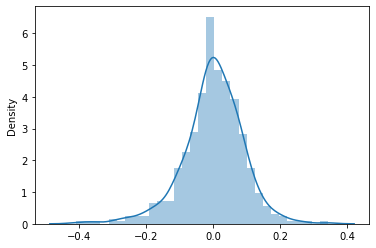

In [83]:
res = y_train - y_train_pred
sns.distplot(res)

In [84]:
res.describe()

count    5.110000e+02
mean    -1.972221e-16
std      9.087536e-02
min     -4.095537e-01
25%     -4.390277e-02
50%      2.123373e-03
75%      5.593029e-02
max      3.433397e-01
dtype: float64

In [85]:
y_updated = X_test_sm.drop(var_remove, axis=1)
y_pred = lr_model.predict(y_updated)

/Users/prasad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

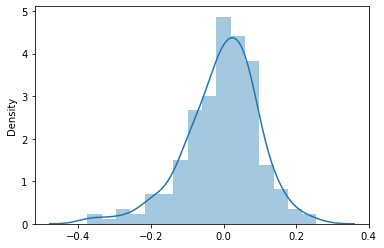

In [86]:
res = y_test - y_pred
sns.distplot(res)

In [87]:
res.describe()

count    219.000000
mean      -0.005706
std        0.101665
min       -0.374847
25%       -0.060540
50%        0.002192
75%        0.060780
max        0.255835
dtype: float64

/Users/prasad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


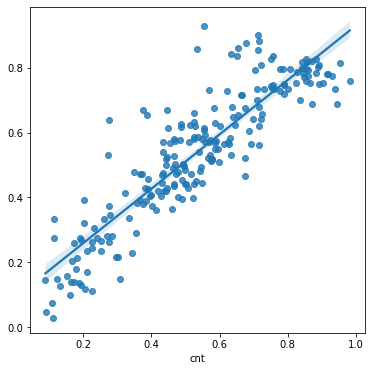

In [88]:
plt.figure(figsize=(6,6))
sns.regplot(y_test, y_pred)
plt.show()

In [89]:
X_updated.head()

,const,yr,workingday,temp,windspeed,weeknumber,spring,summer,winter,Sat,MistorBroken_Clouds,Snow_Rain_ScatteredClouds
instant,,,,,,,,,,,,
708,1.0,1.0,0.0,0.417140,0.243629,0.25,0.0,0.0,1.0,0.0,1.0,0.0
173,1.0,0.0,1.0,0.865247,0.274549,0.75,0.0,0.0,0.0,0.0,0.0,0.0
15,1.0,0.0,0.0,0.223565,0.243603,0.50,1.0,0.0,0.0,1.0,1.0,0.0
205,1.0,0.0,0.0,0.989306,0.267859,0.75,0.0,0.0,0.0,0.0,0.0,0.0
183,1.0,0.0,0.0,0.871664,0.150755,0.00,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
# R-squared value for train data
r2 =r2_score(y_true = y_train, y_pred = y_train_pred)
r2

0.8343333695524516

In [91]:
# R-squared value for test data
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7884372065390197

##### Demand of bike booking depends on yr, workingday, temp, windspeed, weeknumber, spring, winter, Sat, MistBroken_Clouds, Snow_Rain_ScatteredClouds variables.